In [19]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Notebook + project paths
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from ntp_simulation import run_sim, run_batch_sim, load_params

# CSV path
csv_path = os.path.join(project_root, "data", "reactors.csv")


In [20]:
df = pd.read_csv(csv_path)
df.head()


,reactor_name,total_power_MW,inlet_temperature_K,inlet_pressure_Pa,mass_flow_kg_s,core_length_m,n_slices,area_throat_m2,area_exit_m2,inconel718_Tmax_K,cp_J_kg_K,gamma,molar_mass_kg_mol,eta_abs
0,Large_NERVA,555,300,3000000.0,12.68,1.321,100,0.0010,0.010,1000,14000,1.35,0.002,0.9
1,Pewee_1,500,300,3000000.0,10.00,1.000,100,0.0010,0.010,1000,14000,1.35,0.002,0.9
2,Phoebus_2A,4000,300,3000000.0,40.00,1.500,150,0.0020,0.020,1000,14000,1.35,0.002,0.9
3,NRX_A6,1100,300,3000000.0,15.00,1.200,120,0.0015,0.015,1000,14000,1.35,0.002,0.9
4,Particle_Bed_Reactor,1000,300,3000000.0,5.00,0.500,80,0.0008,0.008,1000,14000,1.35,0.002,0.9


In [21]:
params_path = os.path.join(project_root, "src", "params.yaml")
params = load_params(params_path)
out = run_sim(params)

# Show temperature profile
pd.DataFrame({
    "x (m)": out["x"],
    "T_gas (K)": out["T_gas"],
    "T_wall (K)": out["T_wall"]
}).head()


,x (m),T_gas (K),T_wall (K)
0,0.000000,364.285714,414.285714
1,0.052632,459.022556,509.022556
2,0.105263,584.210526,634.210526
3,0.157895,739.849624,789.849624
4,0.210526,925.939850,975.939850


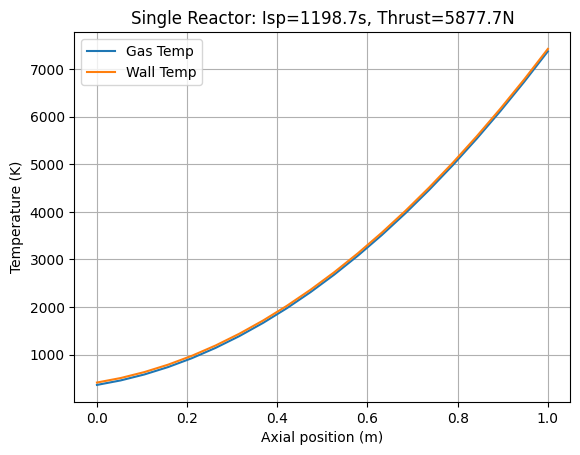

In [22]:
plt.plot(out["x"], out["T_gas"], label="Gas Temp")
plt.plot(out["x"], out["T_wall"], label="Wall Temp")
plt.xlabel("Axial position (m)")
plt.ylabel("Temperature (K)")
plt.title(f'Single Reactor: Isp={out["Isp"]:.1f}s, Thrust={out["thrust"]:.1f}N')
plt.legend()
plt.grid(True)
plt.show()


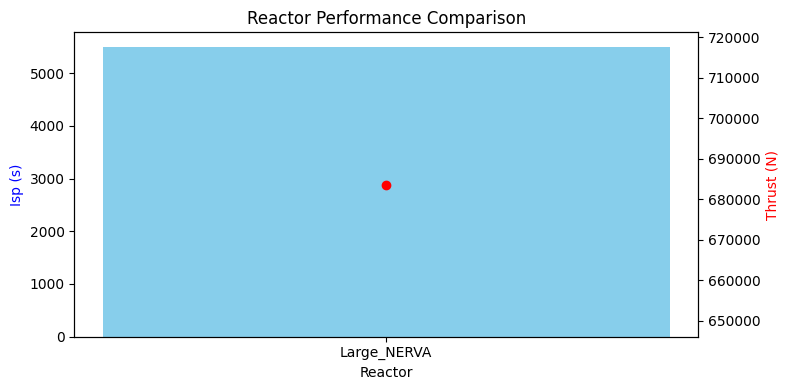

In [23]:
# Run batch simulation
results = run_batch_sim(csv_path)

# Flatten results safely to ensure 'Isp' and 'thrust' exist
cleaned_results = []
for res in results:
    if isinstance(res, dict):
        cleaned_results.append({
            'reactor_name': res.get('reactor_name', 'unknown'),
            'Isp': res.get('Isp', None),
            'thrust': res.get('thrust', None)
        })
    elif isinstance(res, list) and isinstance(res[0], dict):
        r = res[0]
        cleaned_results.append({
            'reactor_name': r.get('reactor_name', 'unknown'),
            'Isp': r.get('Isp', None),
            'thrust': r.get('thrust', None)
        })

# Build dataframe
results_df = pd.DataFrame(cleaned_results)

# Ensure numeric
results_df["Isp"] = pd.to_numeric(results_df["Isp"], errors="coerce")
results_df["thrust"] = pd.to_numeric(results_df["thrust"], errors="coerce")

# Plot bar + line chart
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.bar(results_df["reactor_name"], results_df["Isp"], color="skyblue", label="Isp (s)")
ax2.plot(results_df["reactor_name"], results_df["thrust"], color="red", marker="o", label="Thrust (N)")

ax1.set_xlabel("Reactor")
ax1.set_ylabel("Isp (s)", color="blue")
ax2.set_ylabel("Thrust (N)", color="red")
plt.title("Reactor Performance Comparison")
fig.tight_layout()
plt.show()
